In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load and parse datetime
file_path = r'C:\Users\Dell\Downloads\T1.csv\T1.csv'
data = pd.read_csv(file_path, parse_dates=['Date/Time'], dayfirst=True)
data.set_index('Date/Time', inplace=True)

# Rename for convenience
data.rename(columns={
    'LV ActivePower (kW)': 'power',
    'Wind Speed (m/s)': 'windSpeed',
    'Theoretical_Power_Curve (KWh)': 'theoreticalPower',
    'Wind Direction (°)': 'windDirection'
}, inplace=True)

# Drop missing values in key columns
data.dropna(subset=['power','windSpeed','theoreticalPower'], inplace=True)


              power     windSpeed  theoreticalPower
count  50530.000000  50530.000000      50530.000000
mean    1307.684332      7.557952       1492.175463
std     1312.459242      4.227166       1368.018238
min       -2.471405      0.000000          0.000000
25%       50.677890      4.201395        161.328167
50%      825.838074      7.104594       1063.776283
75%     2482.507568     10.300020       2964.972462
max     3618.732910     25.206011       3600.000000


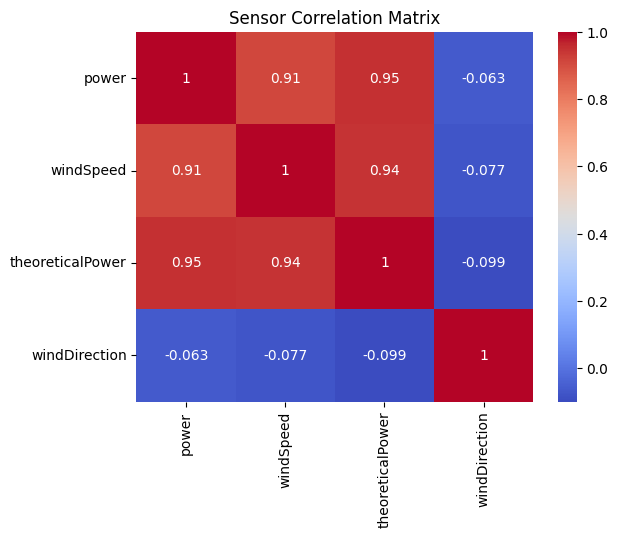

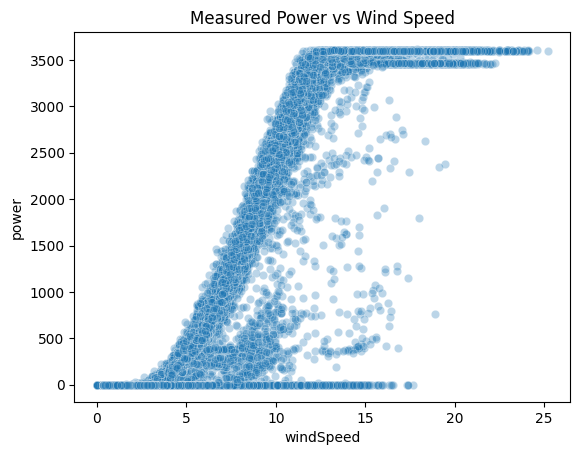

In [2]:
# Summary statistics
print(data[['power','windSpeed','theoreticalPower']].describe())

# Correlation heatmap
sns.heatmap(data[['power','windSpeed','theoreticalPower','windDirection']].corr(), annot=True, cmap='coolwarm')
plt.title('Sensor Correlation Matrix')
plt.show()

# Power curve scatter
sns.scatterplot(x='windSpeed', y='power', data=data, alpha=0.3)
plt.title('Measured Power vs Wind Speed')
plt.show()


In [3]:
features = ['windSpeed','windDirection']
X = data[features]
y = data['power']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [4]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf')
}

results = []

for name, model in models.items():
    if name == 'Support Vector Regression':
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2  = r2_score(y_test, preds)
    
    results.append({
        'Model': name, 'R²': r2, 'RMSE': rmse, 'MAE': mae
    })


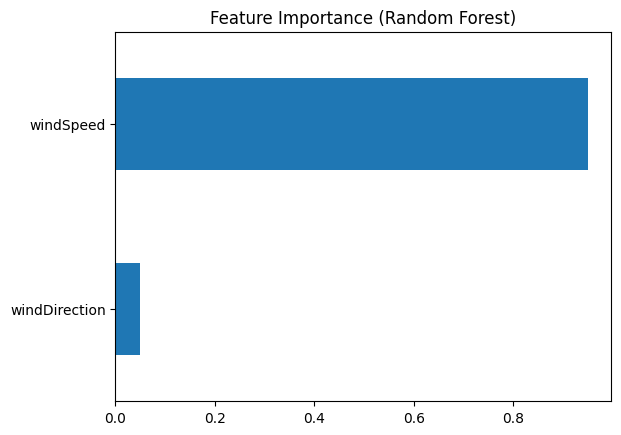

In [5]:
# Use Random Forest for importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=features).sort_values()
importances.plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.show()


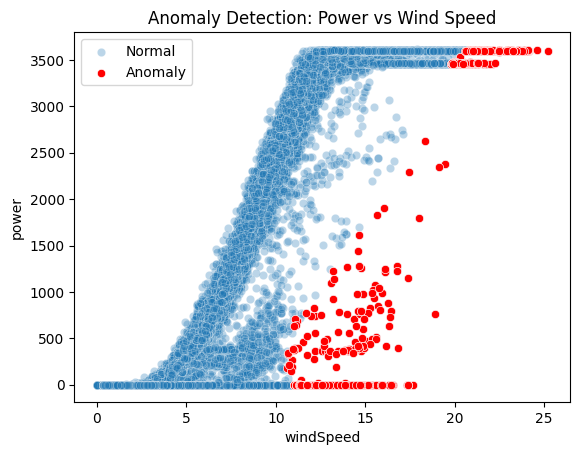

In [6]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01, random_state=42)
data['anomaly'] = iso.fit_predict(data[['power','windSpeed','theoreticalPower']])
anomalies = data[data['anomaly']==-1]

sns.scatterplot(x='windSpeed', y='power', data=data, alpha=0.3, label='Normal')
sns.scatterplot(x='windSpeed', y='power', data=anomalies, color='red', label='Anomaly')
plt.title('Anomaly Detection: Power vs Wind Speed')
plt.legend()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_18752\4216741854.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  power_ts = data['power'].asfreq('H').fillna(method='ffill')
C:\Users\Dell\AppData\Local\Temp\ipykernel_18752\4216741854.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  power_ts = data['power'].asfreq('H').fillna(method='ffill')


ARIMA RMSE: 1530.21


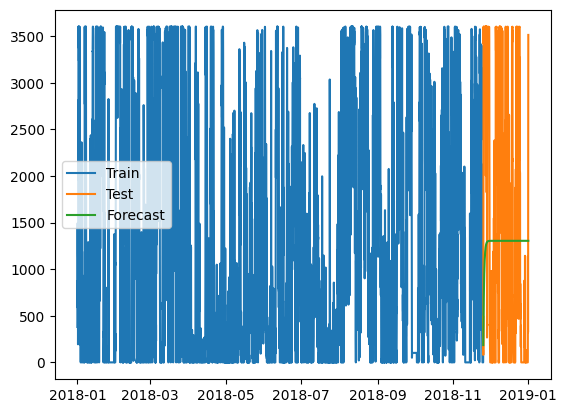

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

power_ts = data['power'].asfreq('H').fillna(method='ffill')
train, test = power_ts[:int(len(power_ts)*0.9)], power_ts[int(len(power_ts)*0.9):]

model = ARIMA(train, order=(5,1,1)).fit()
forecast = model.forecast(steps=len(test))
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'ARIMA RMSE: {rmse:.2f}')

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()


Gradient Boosting Results:
R²: 0.9140
MAE: 160.5819
RMSE: 383.0466

Random Forest Results:
R²: 0.9000
MAE: 171.0235
RMSE: 413.0511

Feature Importance:
         feature  importance
0      windSpeed    0.950568
1  windDirection    0.049432


C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



LSTM Results:
R²: 0.9695
MAE: 137.7336
RMSE: 234.2577


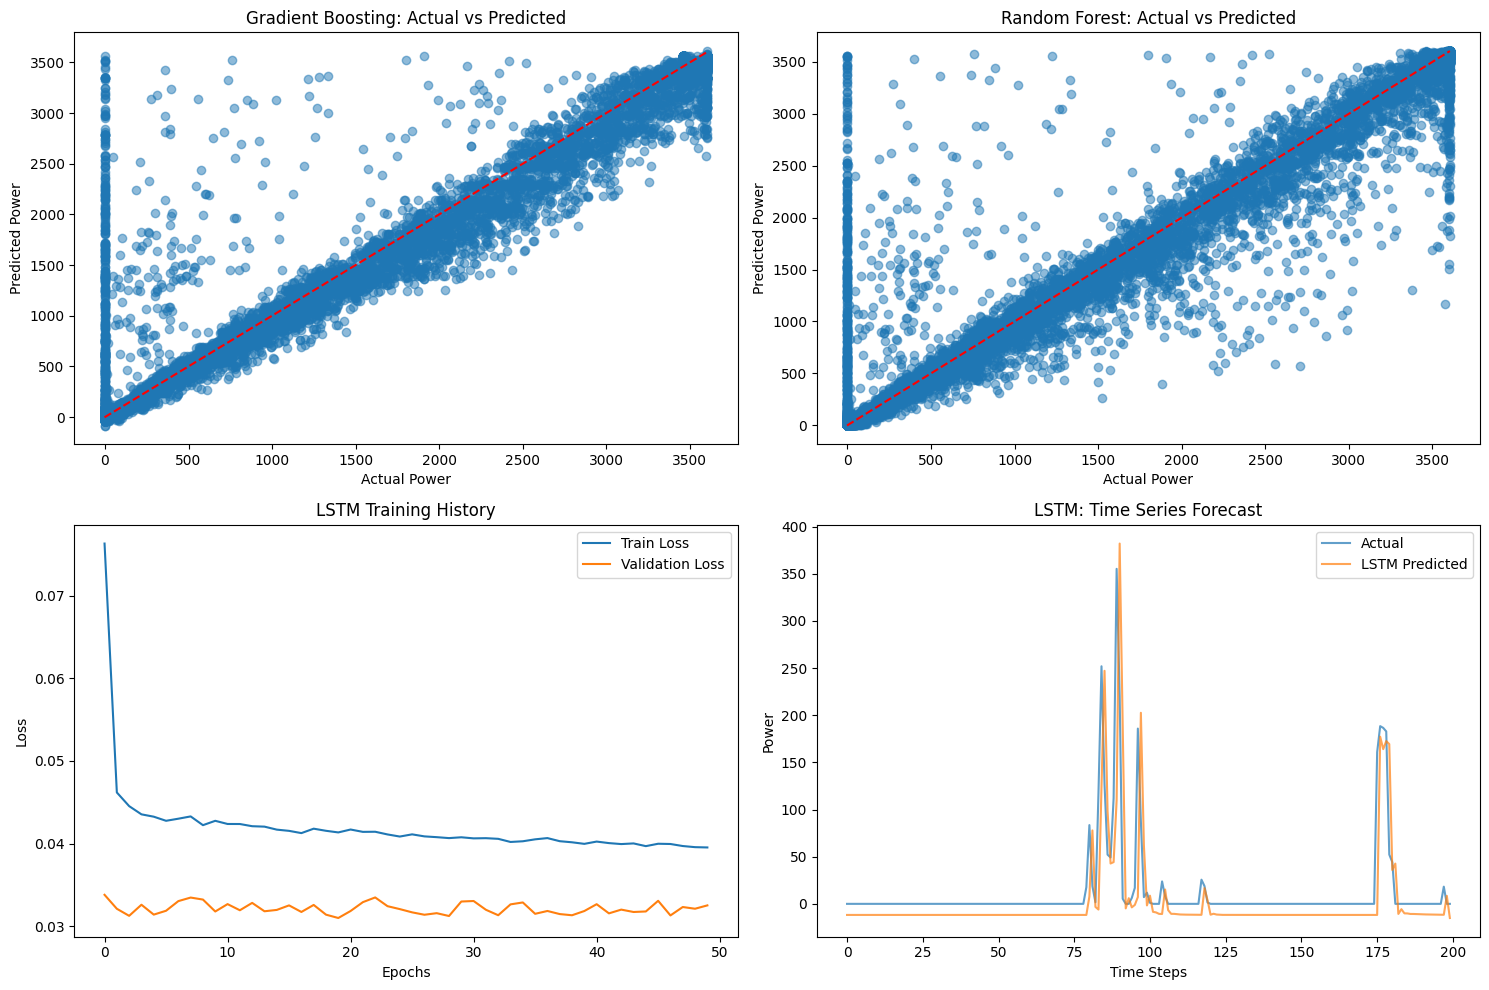

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assume data is loaded and cleaned
# Create features and target
features = ['windSpeed', 'windDirection']
target = 'power'

X = data[features].dropna()
y = data[target].loc[X.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. GRADIENT BOOSTING (XGBoost alternative)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

print("Gradient Boosting Results:")
print(f"R²: {r2_score(y_test, gb_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, gb_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, gb_pred)):.4f}")

# 2. RANDOM FOREST REGRESSOR
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("\nRandom Forest Results:")
print(f"R²: {r2_score(y_test, rf_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, rf_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred)):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(f"\nFeature Importance:\n{feature_importance}")

# 3. LSTM FOR TIME SERIES FORECASTING
def create_lstm_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Prepare data for LSTM (using only power for univariate forecasting)
scaler = StandardScaler()
power_scaled = scaler.fit_transform(data['power'].values.reshape(-1, 1)).flatten()

# Create sequences (60 timesteps to predict next value)
n_steps = 60
X_lstm, y_lstm = create_lstm_sequences(power_scaled, n_steps)

# Train-test split for LSTM
split_idx = int(len(X_lstm) * 0.8)
X_lstm_train, X_lstm_test = X_lstm[:split_idx], X_lstm[split_idx:]
y_lstm_train, y_lstm_test = y_lstm[:split_idx], y_lstm[split_idx:]

# Reshape for LSTM (samples, timesteps, features)
X_lstm_train = X_lstm_train.reshape(X_lstm_train.shape[0], X_lstm_train.shape[1], 1)
X_lstm_test = X_lstm_test.reshape(X_lstm_test.shape[0], X_lstm_test.shape[1], 1)

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_steps, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train LSTM
history = lstm_model.fit(
    X_lstm_train, y_lstm_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

# LSTM predictions
lstm_pred_scaled = lstm_model.predict(X_lstm_test, verbose=0)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()
y_lstm_test_actual = scaler.inverse_transform(y_lstm_test.reshape(-1, 1)).flatten()

print("\nLSTM Results:")
print(f"R²: {r2_score(y_lstm_test_actual, lstm_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_lstm_test_actual, lstm_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_lstm_test_actual, lstm_pred)):.4f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gradient Boosting
axes[0,0].scatter(y_test, gb_pred, alpha=0.5)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,0].set_title('Gradient Boosting: Actual vs Predicted')
axes[0,0].set_xlabel('Actual Power')
axes[0,0].set_ylabel('Predicted Power')

# Random Forest
axes[0,1].scatter(y_test, rf_pred, alpha=0.5)
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,1].set_title('Random Forest: Actual vs Predicted')
axes[0,1].set_xlabel('Actual Power')
axes[0,1].set_ylabel('Predicted Power')

# LSTM Training History
axes[1,0].plot(history.history['loss'], label='Train Loss')
axes[1,0].plot(history.history['val_loss'], label='Validation Loss')
axes[1,0].set_title('LSTM Training History')
axes[1,0].set_xlabel('Epochs')
axes[1,0].set_ylabel('Loss')
axes[1,0].legend()

# LSTM Predictions
axes[1,1].plot(y_lstm_test_actual[:200], label='Actual', alpha=0.7)
axes[1,1].plot(lstm_pred[:200], label='LSTM Predicted', alpha=0.7)
axes[1,1].set_title('LSTM: Time Series Forecast')
axes[1,1].set_xlabel('Time Steps')
axes[1,1].set_ylabel('Power')
axes[1,1].legend()

plt.tight_layout()
plt.show()
